In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from OCD import *

rng = np.random.seed(0)

In [41]:
import numpy as np

def equicorrelation_cov(n, rho, variance=1.0):
    """
    Generate an n x n equicorrelation covariance matrix.
    
    Parameters:
        n (int): Dimension of the covariance matrix
        rho (float): Correlation coefficient (-1/(n-1) < rho < 1)
        variance (float): Variance along the diagonal (default=1.0)
    
    Returns:
        np.ndarray: n x n covariance matrix
    """
    if not (-1.0/(n-1) < rho < 1.0):
        raise ValueError(f"rho must be in (-1/(n-1), 1) for positive definiteness. Got {rho}.")
    
    cov = np.full((n, n), rho * variance)
    np.fill_diagonal(cov, variance)
    return cov

# Example usage
n = 2         # dimension
rho = 0.3     # correlation between any pair
variance = 1  # each variable has variance 1

cov = equicorrelation_cov(n, rho, variance)
print("Equicorrelation covariance matrix:\n", cov)

# Now generate samples
mean = np.zeros(n)
num_samples = 10000
X = np.random.multivariate_normal(mean, cov, size=num_samples)

print("Shape of samples:", X.shape)
print("cov samples:\n", np.cov(X, rowvar=False))


# Uniform over an n-dimensional cube [0,1]^n
Y = np.random.rand(num_samples, n)
Y.shape


Equicorrelation covariance matrix:
 [[1.  0.3]
 [0.3 1. ]]
Shape of samples: (10000, 2)
cov samples:
 [[0.97954444 0.31522771]
 [0.31522771 1.01093904]]


(10000, 2)

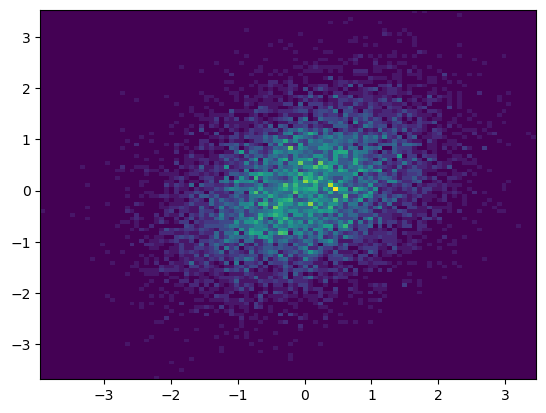

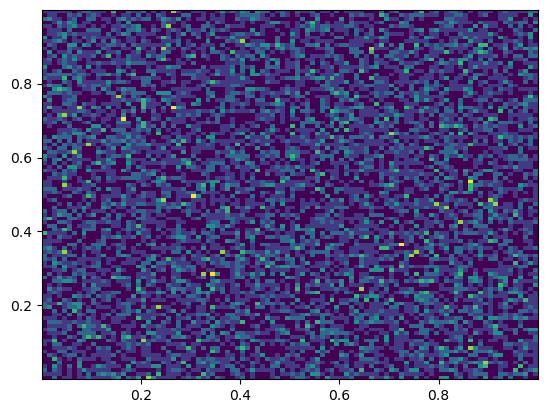

In [42]:
plt.figure()
_ = plt.hist2d(X[:,0], X[:,1],bins=100)

plt.figure()
_ = plt.hist2d(Y[:,0], Y[:,1],bins=100)

epsilon =  0.0165213340635737


Text(0.5, 0, 'Iteration')

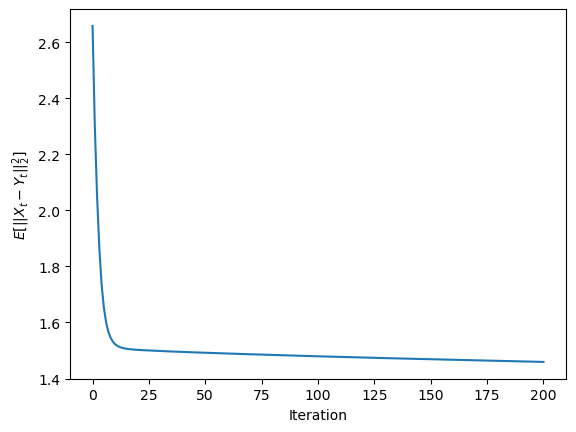

In [43]:
X0 = X.copy()
Y0 = Y.copy()

eps0 = find_opt_eps2(X0, Y0, log_eps_range=[-3,0], nepss = 400, perc=0.9998)
print("epsilon = ", eps0)

dt = 0.1
Nt = 200
tol = 1e-4

X_ocd, Y_ocd, dists, err_m2X, err_m2Y = ocd_map_RK4(X0, Y0, dt=dt, Nt=200, sigma=eps0, tol=tol)

plt.figure()
plt.plot(dists)
plt.ylabel(r"$E[||X_t-Y_t||_2^2]$")
plt.xlabel("Iteration")   


In [95]:
import numpy as np
import time
import matplotlib.pyplot as plt

def equicorrelation_cov(n, rho, variance=1.0):
    """
    Generate an n x n equicorrelation covariance matrix.
    """
    if not (-1.0/(n-1) < rho < 1.0):
        raise ValueError(f"rho must be in (-1/(n-1), 1) for positive definiteness. Got {rho}.")
    
    cov = np.full((n, n), rho * variance)
    np.fill_diagonal(cov, variance)
    return cov


# Benchmark setup
dims = [2, 3, 4, 5, 6, 7, 8, 9, 10]
num_repeats = 5
num_samples = 1000
rho = 0.1
variance = 1

# Open file once in append mode
with open("timings.txt", "w") as f:
    f.write("dim mean_time std_time\n")  # header

for n in dims:
    times = []
    cov = equicorrelation_cov(n, rho, variance)
    mean = np.zeros(n)
    for rep in range(num_repeats):
        print(f"n={n}, {rep+1}/{num_repeats}")
        

        X = np.random.multivariate_normal(mean, cov, size=num_samples)
        Y = np.random.rand(num_samples, n)
        if rep==0:
            eps0 = find_opt_eps2(X, Y, log_eps_range=[-4,1], nepss=400, perc=0.9998)
        dt, Nt, tol = 0.1, 200, 1e-4
        
        start = time.time()
        X_ocd, Y_ocd, dists, err_m2X, err_m2Y = ocd_map_RK4(X, Y, dt=dt, Nt=Nt, sigma=eps0, tol=tol)
        end = time.time()
        
        times.append(end - start)
        del X, Y, X_ocd, Y_ocd
    
    mean_time, std_time = np.mean(times), np.std(times)
    
    # Append result for this n immediately
    with open("timings.txt", "a") as f:
        f.write(f"{n} {mean_time:.6f} {std_time:.6f}\n")

print("Timings written incrementally to timings.txt")

n=2, 1/5
n=2, 2/5
n=2, 3/5
n=2, 4/5
n=2, 5/5
n=3, 1/5
n=3, 2/5
n=3, 3/5
n=3, 4/5
n=3, 5/5
n=4, 1/5
n=4, 2/5
n=4, 3/5
n=4, 4/5
n=4, 5/5
n=5, 1/5
n=5, 2/5
n=5, 3/5
n=5, 4/5
n=5, 5/5
n=6, 1/5
n=6, 2/5
n=6, 3/5
n=6, 4/5
n=6, 5/5
n=7, 1/5
n=7, 2/5
n=7, 3/5
n=7, 4/5
n=7, 5/5
n=8, 1/5
n=8, 2/5
n=8, 3/5
n=8, 4/5
n=8, 5/5
n=9, 1/5
n=9, 2/5
n=9, 3/5
n=9, 4/5
n=9, 5/5
n=10, 1/5
n=10, 2/5
n=10, 3/5
n=10, 4/5
n=10, 5/5
Timings written incrementally to timings.txt


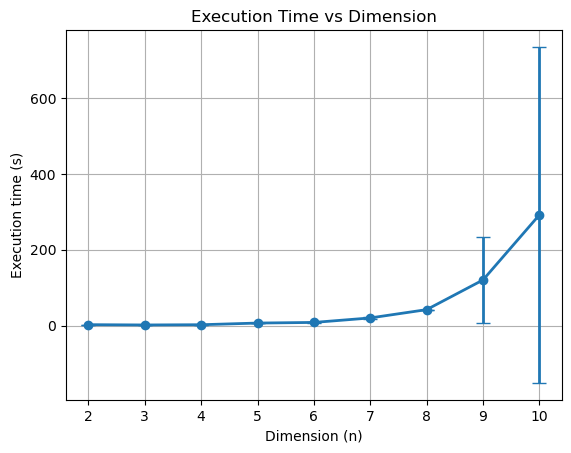

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Load timings
data = np.loadtxt("timings.txt", skiprows=1)
dims = data[:,0].astype(int)
means = data[:,1]
stds = data[:,2]

# Plot with error bars
plt.errorbar(dims, means, yerr=stds, fmt='o-', capsize=5, lw=2)
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Dimension (n)")
plt.ylabel("Execution time (s)")
plt.title("Execution Time vs Dimension")
plt.grid(True)
plt.show()


Fitted exponential function: y = exp(-1.374459) * exp(0.658966 * x)


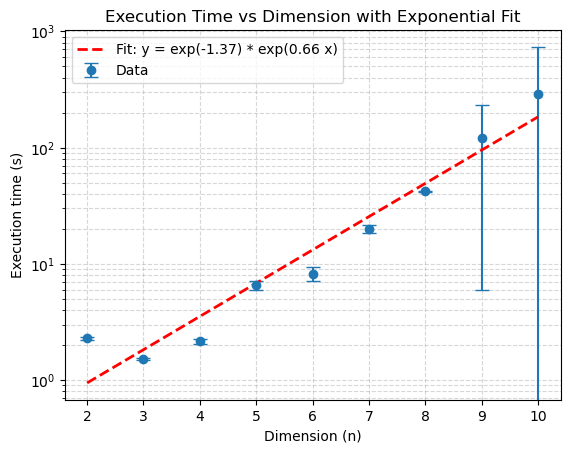

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Load timings
data = np.loadtxt("timings.txt", skiprows=1)
dims = data[:,0].astype(int)
means = data[:,1]
stds = data[:,2]

# Fit a linear function to log(y): log(y) = a * x + b => y = exp(b) * exp(a*x)
log_means = np.log(means)
coeffs_log = np.polyfit(dims, log_means, 1)  # linear fit in log-space
a, b = coeffs_log
print(f"Fitted exponential function: y = exp({b:.6f}) * exp({a:.6f} * x)")

# Compute fitted values in original space
y_fit_log = np.exp(b) * np.exp(a * dims)

# Plot data with error bars
plt.errorbar(dims, means, yerr=stds, fmt='o', capsize=5, label="Data")
plt.plot(dims, y_fit_log, 'r--', lw=2, label=f"Fit: y = exp({b:.2f}) * exp({a:.2f} x)")

plt.yscale("log")
plt.xlabel("Dimension (n)")
plt.ylabel("Execution time (s)")
plt.title("Execution Time vs Dimension with Exponential Fit")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()


Fitted linear function: y = 26.807997 * x + -105.831503


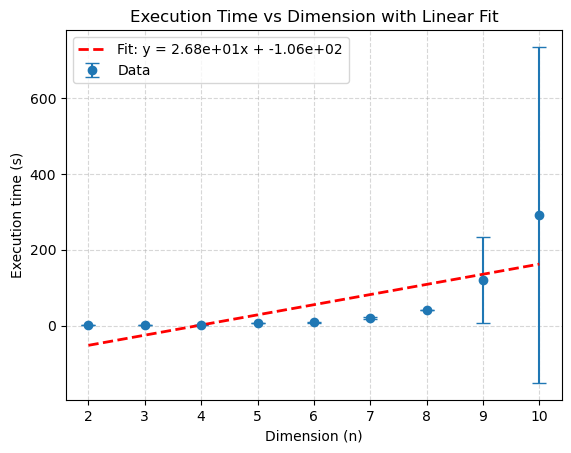

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Load timings
data = np.loadtxt("timings.txt", skiprows=1)
dims = data[:,0].astype(int)
means = data[:,1]
stds = data[:,2]

# Fit linear function: y = a * x + b
coeffs = np.polyfit(dims, means, 1)  # degree=1 for linear
a, b = coeffs
print(f"Fitted linear function: y = {a:.6f} * x + {b:.6f}")

# Compute fitted values
y_fit = a * dims + b

# Plot data with error bars
plt.errorbar(dims, means, yerr=stds, fmt='o', capsize=5, label="Data")
plt.plot(dims, y_fit, 'r--', lw=2, label=f"Fit: y = {a:.2e}x + {b:.2e}")

#plt.yscale("log")  # keep log scale if desired
plt.xlabel("Dimension (n)")
plt.ylabel("Execution time (s)")
plt.title("Execution Time vs Dimension with Linear Fit")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()
